In [1]:
# loading necessary libraries
import json
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from src.PostAnalysis import BinSamples
from src.PostProcessing import HuffmanEncoding

# fixing global variables
plt.style.use("bmh")
rcParams["figure.figsize"] = (20, 10)
n, m, n_param, v, N = 4, 4, 5, 0, 10000
data_path = "data/n{}_m{}_nparam{}_v{}".format(n, m, n_param, v)

## Boson Sampling using _fock_ backend
### Architecture
The architecture of the Boson Sampler (BS) used throughout this study is as follows

<p align="center">
<img src="figs/architecture.png"
     alt="Markdown Monster icon"/>
</p>

It has four modes and four photons enter from the left side (shown in red circles). The Beam splitters are shown in yellow rectangles and have their transmittivity $\theta$ set is to $\pi/4$ and phase angle $\phi$ to $0$. The photodetectors are shown as blue semi-circles on the right hand side.

The exact solution of the probabilities of the fock states for the BS shown above is depicted in the following bar plot.

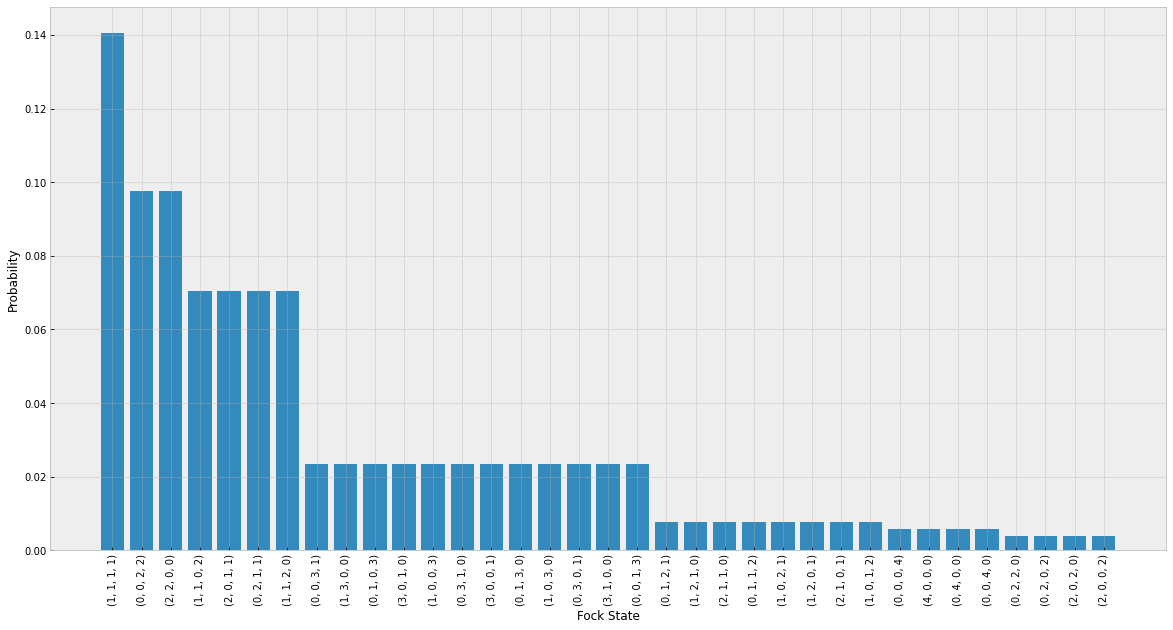

In [2]:
with open("{}/exact_result.json".format(data_path), "r") as f:
    fock_dist = json.load(f)

plt.bar(list(fock_dist.keys()), list(fock_dist.values()))
plt.ylabel("Probability")
plt.xlabel("Fock State")
plt.xticks(rotation=90);

### Von Neumann Post-Processing
The von Neumann debiasing discussed in [[1]](https://arxiv.org/abs/2206.02292) takes two sampled fock states and convert them to two binary states e.g. take two fock states _(0, 2, 0, 2)_ and _(0, 0, 0, 4)_, their binary representations are _(0, 1, 0, 1)_ and _(0, 0, 0, 1)_ respectively. Then elementwise, apply the following protocol 

bit 1 | bit 2 | output
----- | ----- | ------
  0   |   0   |   *
  0   |   1   |   0
  1   |   0   |   1
  1   |   1   |   *

Where _*_ stands on discarded. Hence for the two fock states above, the extracted binary string yields _\*1\*\*_ which simplifies to _1_. After measuring the BS $10^4$ and recording the binary strings after the von Neumann debiasing the following histogram is yielded.

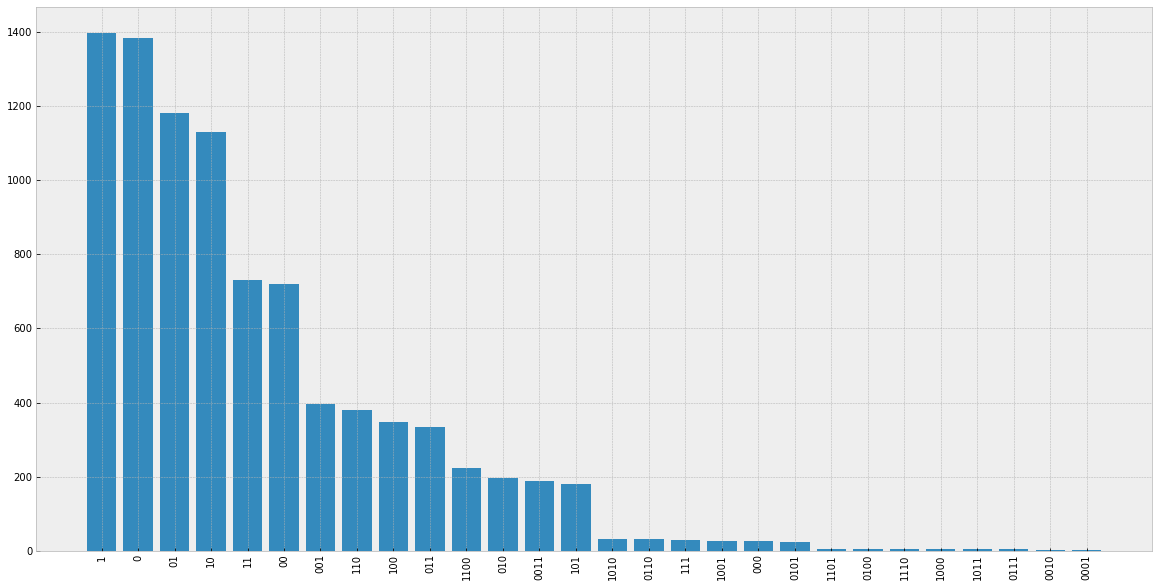

In [3]:
with open("{}/vonneumann_strs_N{}.json".format(data_path, N)) as f:
    von_neumann_strs = json.load(f)
occurrences = Counter(von_neumann_strs)
occurrences = [(key, val) for key, val in occurrences.items()]
occurrences.sort(key=lambda x: x[1], reverse=True)
occurrences = {el[0]: el[1] for el in occurrences}
plt.bar(list(occurrences.keys()), list(occurrences.values()))
plt.xticks(rotation=90);

A contineous stream of these binary strings which is yielded by concatenating them consequtively, is supposed to produce an unbiased appearance of the bits _0_ and _1_ i.e. the number of _0_'s is as much as the number of _1_'s in the string when the length of the stream tends to infinity.

In [4]:
neumann_samp = BinSamples(von_neumann_strs)
trunc_indices = range(10, len(von_neumann_strs), 10)
neumann_ratio = neumann_samp.truncated_ensemble(trunc_indices=trunc_indices)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 243 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 813 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-2)]: Done 899 out of 899 | elapsed:    1.2s finished


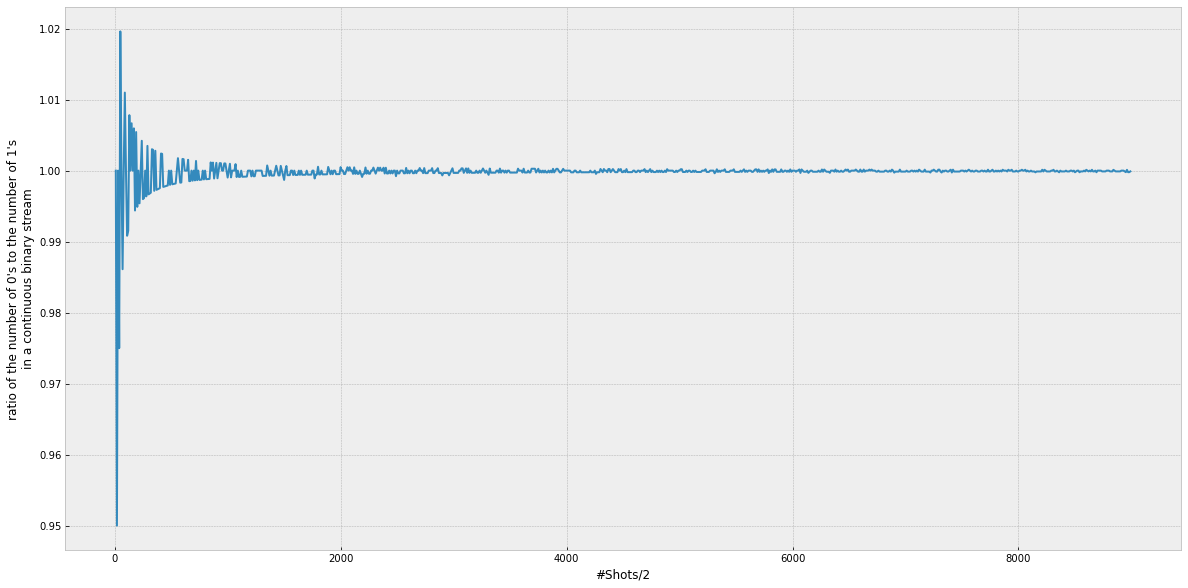

In [5]:
zero_one_diff = [abs(neumann_ratio[key]["ratio"]["0"]/neumann_ratio[key]["ratio"]["1"]) for key in neumann_ratio.keys()]
plt.plot(list(neumann_ratio.keys()), zero_one_diff)
plt.ylabel("ratio of the number of 0's to the number of 1's\nin a continuous binary stream")
plt.xlabel("#Shots/2");

As demonstrated in the figure above, it is easy to verify that the number of _0_'s in a continuous stream of binary stream as as high as the number of _1_'s within the same stream.

In [6]:
%%sh
cat data/n4_m4_nparam5_v0/vonneumann_strs_N10000.json | grep -Po '^(.*?,){4000}' | sed 's/[\[, "]//g' | djent -l 1

   Min Entropy (by max occurrence of symbol 0) = 0.192639
   Analysing 32568 1-bit symbols
   Shannon IID Entropy = 0.543554 bits per symbol
   Optimal compression would compress by 45.644633 percent
   Chi square: symbol count=32569, distribution=18320.44, randomly exceeds 0.00 percent of the time
   Mean = 0.125000
   Monte Carlo value for Pi is 4.000000 (error 27.32 percent).
   Serial Correlation = -0.142857
   Longest Run Symbol = 0. Run Length = 19
   Probabilty of longest run being <= 19 = 0.969425
   Position of Longest Run = 2 (0x2). Byte position 0 (0x0)


### Huffman Encoding Post-Processing
the von Neumann post-processing requires two input states (fock states). This consequently leads to a lower bit-rate. Moreover it requires an extra bit-wise operation to extract the entropy out of the non-uniform fock states. Besides, it happens quite often that we produce the empty string since the two fock states are the same. To overcome these disadvantages, a new encoding scheme is suggested here called Huffman encoding. In this encoding scheme the fock states are assigned to a binary string. The higher the probability of the appearance of a given fock state is, the shorter the binary string encoding is. This leads to an efficient encoding (the most efficient encoding actually) of the fock states into binary representation. For instance for the fock states illustrated above we have the following encoding

In [7]:
with open("data/n4_m4_nparam5_v0/exact_result.json", "r") as f:
    fock_probs = json.load(f)
huff_enc = HuffmanEncoding(fock_probs)
huff_enc.huffman_encoding()
{key: val[0] for key, val in huff_enc.encoding.items()}

{'(1, 1, 1, 1)': '101',
 '(0, 0, 2, 2)': '001',
 '(2, 2, 0, 0)': '010',
 '(1, 1, 0, 2)': '1100',
 '(2, 0, 1, 1)': '1101',
 '(0, 2, 1, 1)': '1000',
 '(1, 1, 2, 0)': '1001',
 '(0, 0, 3, 1)': '01101',
 '(1, 3, 0, 0)': '01100',
 '(0, 1, 0, 3)': '00010',
 '(3, 0, 1, 0)': '00011',
 '(1, 0, 0, 3)': '00001',
 '(0, 3, 1, 0)': '111111',
 '(3, 0, 0, 1)': '00000',
 '(0, 1, 3, 0)': '111110',
 '(1, 0, 3, 0)': '111100',
 '(0, 3, 0, 1)': '111011',
 '(3, 1, 0, 0)': '111010',
 '(0, 0, 1, 3)': '111001',
 '(0, 1, 2, 1)': '1110000',
 '(1, 2, 1, 0)': '0111111',
 '(2, 1, 1, 0)': '0111110',
 '(0, 1, 1, 2)': '0111101',
 '(1, 0, 2, 1)': '0111100',
 '(1, 2, 0, 1)': '0111011',
 '(2, 1, 0, 1)': '0111010',
 '(1, 0, 1, 2)': '0111000',
 '(0, 0, 0, 4)': '11110111',
 '(4, 0, 0, 0)': '11110110',
 '(0, 4, 0, 0)': '11110101',
 '(0, 0, 4, 0)': '11110100',
 '(0, 2, 2, 0)': '11100011',
 '(0, 2, 0, 2)': '01110011',
 '(2, 0, 2, 0)': '11100010',
 '(2, 0, 0, 2)': '01110010'}

It is obvious if we simply convert a sequence of fock states and convert them to their binary representation, the final stream of the binary string is biased. To elaborate this and justify this further, take the most probable fock state which is (1, 1, 1, 1). This fock state is encoded by _101_ binary code which is already biased as 2/3 in favour of the bit _1_. Eventually, sampling more and more of this fock state produces an enormous bias of generating more _1_ bit. To resolve this issue, we can flip the bits every time we use one specific codeword. For instance, the first time we use _101_ for encoding the fock state (1, 1, 1, 1), for the next time when we sample this very fock state we flip the bits and use _010_. This way, we ensure that we remove the bias in the long run.

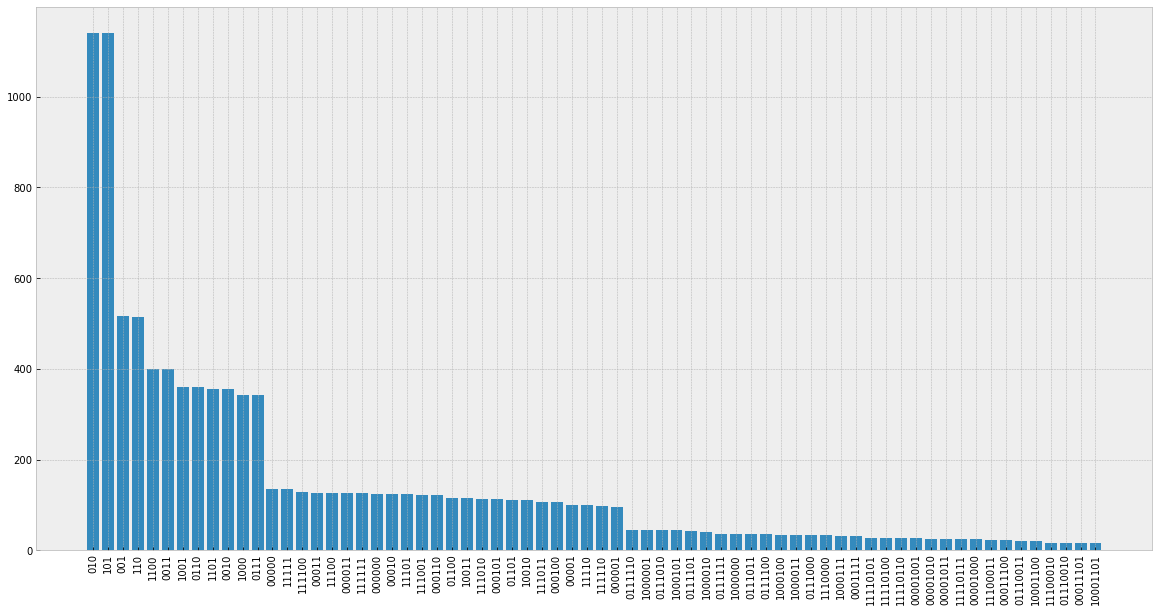

In [8]:
with open("{}/huffman_strs_N{}.json".format(data_path, N)) as f:
    huffman_strs = json.load(f)
occurrences = Counter(huffman_strs)
occurrences = [(key, val) for key, val in occurrences.items()]
occurrences.sort(key=lambda x: x[1], reverse=True)
occurrences = {el[0]: el[1] for el in occurrences}
plt.bar(list(occurrences.keys()), list(occurrences.values()))
plt.xticks(rotation=90);

In [9]:
huffman_samp = BinSamples(huffman_strs)
trunc_indices = range(10, len(huffman_strs), 10)
huffman_ratio = huffman_samp.truncated_ensemble(trunc_indices=trunc_indices)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 336 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-2)]: Done 970 out of 999 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done 999 out of 999 | elapsed:    1.0s finished


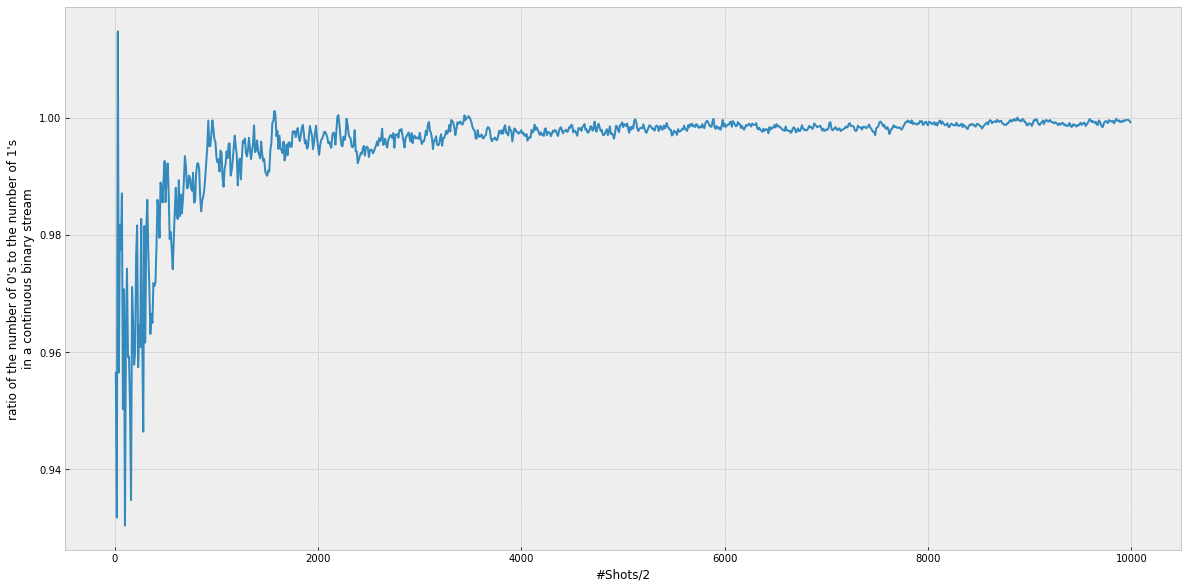

In [10]:
zero_one_diff = [abs(huffman_ratio[key]["ratio"]["0"]/huffman_ratio[key]["ratio"]["1"]) for key in huffman_ratio.keys()]
plt.plot(list(huffman_ratio.keys()), zero_one_diff)
plt.ylabel("ratio of the number of 0's to the number of 1's\nin a continuous binary stream")
plt.xlabel("#Shots/2");

It is seen that the ration between the _0_ bits and the _1_ bits converge to unity when the length of the binary stream grows. The pace it which the ration converge to unity here compared to the von Neumann post-processing is indeed slower, yet we are able to achieve a higher bit rate (produce longer stream) as every single sampled fock state contributes to the stream not two.